**Просматриваем и анализируем  исходные данные 2022 г по измененной сетке**

В этом руководстве мы используем модель трансформатора временного слияния из библиотеки прогнозирования PyTorch и PyTorch 

In [1]:
import warnings
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
#from pytorch_lightning.strategies import DDPStrategy
from pytorch_lightning.strategies import ParallelStrategy
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
#from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [2]:
from rffi_utils import generate_int_id, display_data,\
    show_correlation, create_features, get_boxplot

In [3]:
# Исходные данные
#data = pd.read_csv(r'D:\tmp\svod_1_6.csv')
# Получение данные из sse_power: D:\WorkE\rffi2022\sse_power_parameters.xlsx
data = pd.read_csv(r'F:\svod.csv')

#### Данные 
- 2486 - Мурманск (69, 33)
- 3702 - Астрахань (46, 47)
- 5221 - Иркутск (52, 103)
- 6087 - Казань (55, 48)
- 6128 - Москва (55,37)
- 6260 - Тюмень (57,65) 

In [4]:
arr_sse = []
for i in [10,12,17,18,20,23,27,38,39,40,29,30]: # дневные и 3-часовки
    arr_sse.append('sse_%s'%i)
    data['sse_%s'%i].fillna(0, inplace=True)

In [5]:
for i in [15,42,45]: # почасовки
    arr_sse.append('sse_%s'%i)
    data['sse_%s'%i].fillna(method='ffill', limit=1, inplace=True)
    data['sse_%s'%i].fillna(method='bfill', limit=1, inplace=True)
    data['sse_%s'%i].fillna(0, inplace=True)
#arr_sse  

- **sse_10** Monthly Averaged Diffuse Radiation Incident On A Horizontal Surface (kWh/m2/day)
- **sse_12** Monthly Averaged Direct Normal Radiation (kWh/m2/day)
- **sse_17** Monthly Averaged Insolation Normalized Clearness Index (0 to 1.0)
- **sse_18** Monthly Averaged Clear Sky Insolation Incident On A Horizontal Surface (kWh/m2/day)
- **sse_20** Monthly Averaged Clear Sky Insolation Normalized Clearness Index (0 to 1.0)
- **sse_23** Monthly Averaged Daylight Hours (hours)
- **sse_27** Monthly Averaged Sunset Hour Angle (degrees)
- **sse_38** Solar Radiation Deficits Below Expected Values Incident On A Horizontal Surface Over A Consecutive-day Period (kWh/m2)
- **sse_39** Equivalent Number Of NO-SUN Or BLACK Days (days)
- **sse_40** Available Surplus Insolation Over A Consecutive-day Period (%)
- **sse_29** Monthly Averaged Hourly Solar Angles Relative To The Horizon (degrees)
- **sse_30** Monthly Averaged Hourly Solar Azimuth Angles (degrees)
- **sse_15** Monthly Averaged Downward Longwave Radiative Flux (kWh/m2/day)
- **sse_42** Monthly Averaged Cloud Amount At Indicated GMT Times (%)
- **sse_45** Monthly Averaged Frequency Of Near-overcast Skies At Indicated GMT Times (%)

In [6]:
data['datatime'].agg(['min', 'max'])

min    2020-01-15 01:00:00
max    2022-04-01 00:00:00
Name: datatime, dtype: object

Во-первых, нам нужно преобразовать наш временной ряд в фрейм данных pandas, где каждая строка может быть идентифицирована с временным шагом и временным рядом.Набор данных, описывающий часовые данные по радиации для 6 различные географических точек. Наша задача - составить 24-часовой прогноз по выработкам для 2 устройств: hevel395 и jam72s. Существует 19368 почасовых исторических записей о погоде и выработке для каждой точки за прошлые 2 года. В дополнение к историческим данным возможно найти информацию о различных природных и климатических данных по местоположению точки: высота над уровнем моря, точка росы, загрязненность воздуха и т.д.

Набор данных уже находится в правильном формате, но в нем отсутствуют некоторые важные функции. Самое главное, нам нужно добавить временной индекс, который увеличивается на единицу для каждого временного шага. Кроме того, полезно добавить функции даты, что в данном случае означает извлечение месяца из записи даты.

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116208 entries, 0 to 116207
Data columns (total 38 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   lat             116208 non-null  int16         
 1   lon             116208 non-null  int16         
 2   month           116208 non-null  int16         
 3   hour            116208 non-null  int16         
 4   datatime        116208 non-null  datetime64[ns]
 5   ceres_5         116208 non-null  float32       
 6   ceres_6         116208 non-null  float32       
 7   ceres_albedo    116208 non-null  float32       
 8   ceres_t_2m      116208 non-null  float32       
 9   ceres_wind      116208 non-null  float32       
 10  ghi             116208 non-null  float32       
 11  albedo          116208 non-null  float32       
 12  t_2m            116208 non-null  float32       
 13  wind            116208 non-null  float32       
 14  ceres_hevel395  116208 non-null  flo

In [6]:
data['datatime'] = pd.to_datetime(data['datatime'])
data['lat'] = np.int16(data['lat'])
data['lon'] = np.int16(data['lon'])

In [7]:
for col in data.columns:
    if data[col].dtypes=='float64':
        data[col] = np.float32(data[col])
    if data[col].dtypes=='int64':
        data[col] = np.int16(data[col])

### EDA для новых признаков

Посмотрим разброс выработок на боксплотах для различныех точек и средние значения по выборке. Ожидаемо, что Иркутск и Астрахань в силу своей географической широты дают большие значения, а Мурманск наименьшие, при этом среднее значение выработки в Иркутске даже больше, чем в Астрахани:

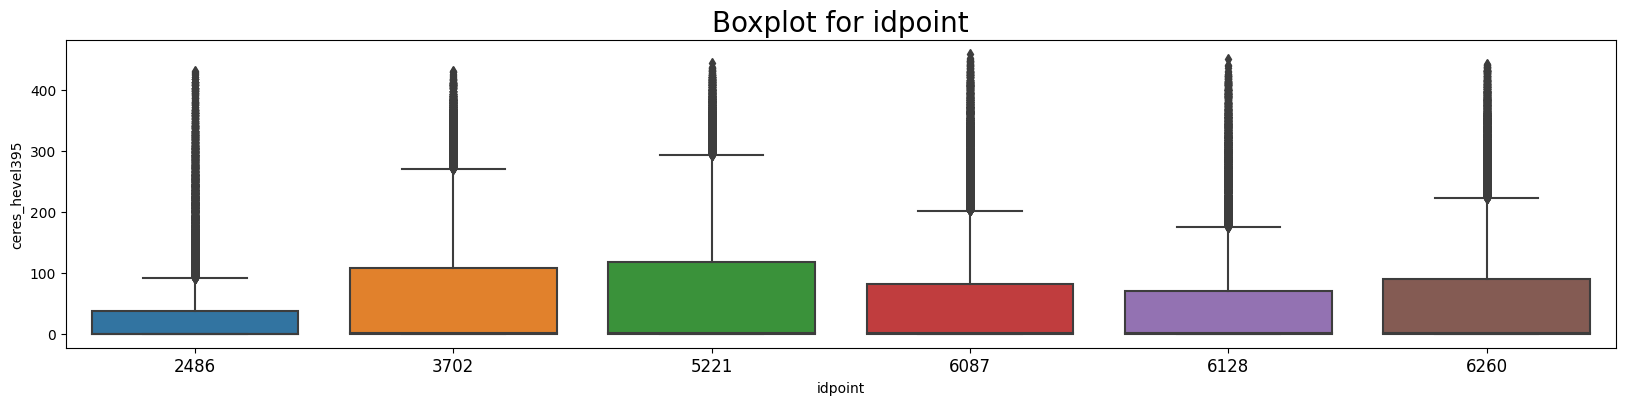

In [10]:
get_boxplot(data, 'idpoint','ceres_hevel395', plt, sns)

In [23]:
data[['idpoint','ceres_hevel395']].groupby('idpoint').mean()

,ceres_hevel395
idpoint,
2486,35.557205
3702,69.250122
5221,71.392166
6087,60.916569
6128,52.955357
6260,62.784103


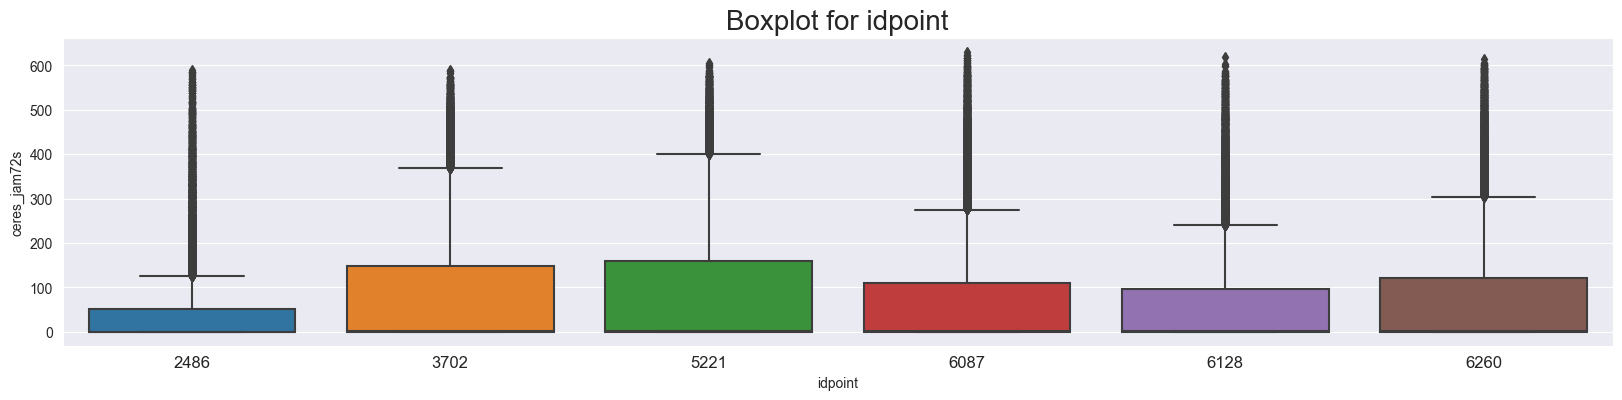

In [17]:
get_boxplot(data, 'idpoint','ceres_jam72s', plt, sns)

In [13]:
data[['idpoint','ceres_jam72s']].groupby('idpoint').mean()

,ceres_jam72s
idpoint,
2486,48.551174
3702,93.788727
5221,97.021553
6087,82.848877
6128,71.958427
6260,85.508469


In [13]:
data[['sse_29', 'sse_30','sse_15', 'sse_42', 'sse_45']].describe()

,sse_29,sse_30,sse_15,sse_42,sse_45
count,116208.000000,116208.000000,116208.000000,116208.000000,116208.000000
mean,11.308228,87.981850,0.116316,40.646832,22.137596
std,15.978151,101.472008,0.165479,30.627995,29.028616
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.010000,57.299999,0.000000
75%,19.700001,180.000000,0.200000,65.599998,54.299999
max,67.000000,349.000000,0.650000,81.900002,78.400002


Посмотрим плотности распределения значений для функций, а также используемых свойств. Тем самым можно будет выдвинуть гипотезы, а в дальнейшем как-то объяснять полученные результаты

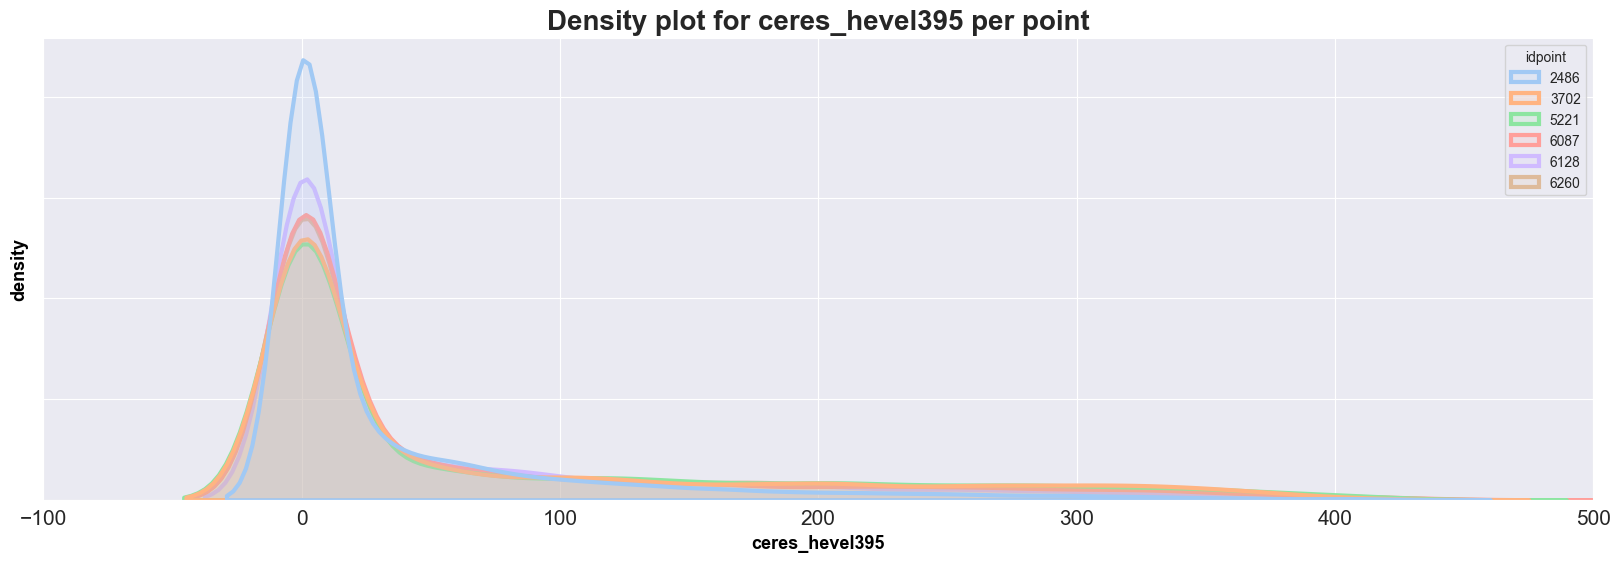

In [14]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'ceres_hevel395', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('ceres_hevel395', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-100, 500)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for ceres_hevel395 per point', fontweight = 'bold', fontsize = 20);

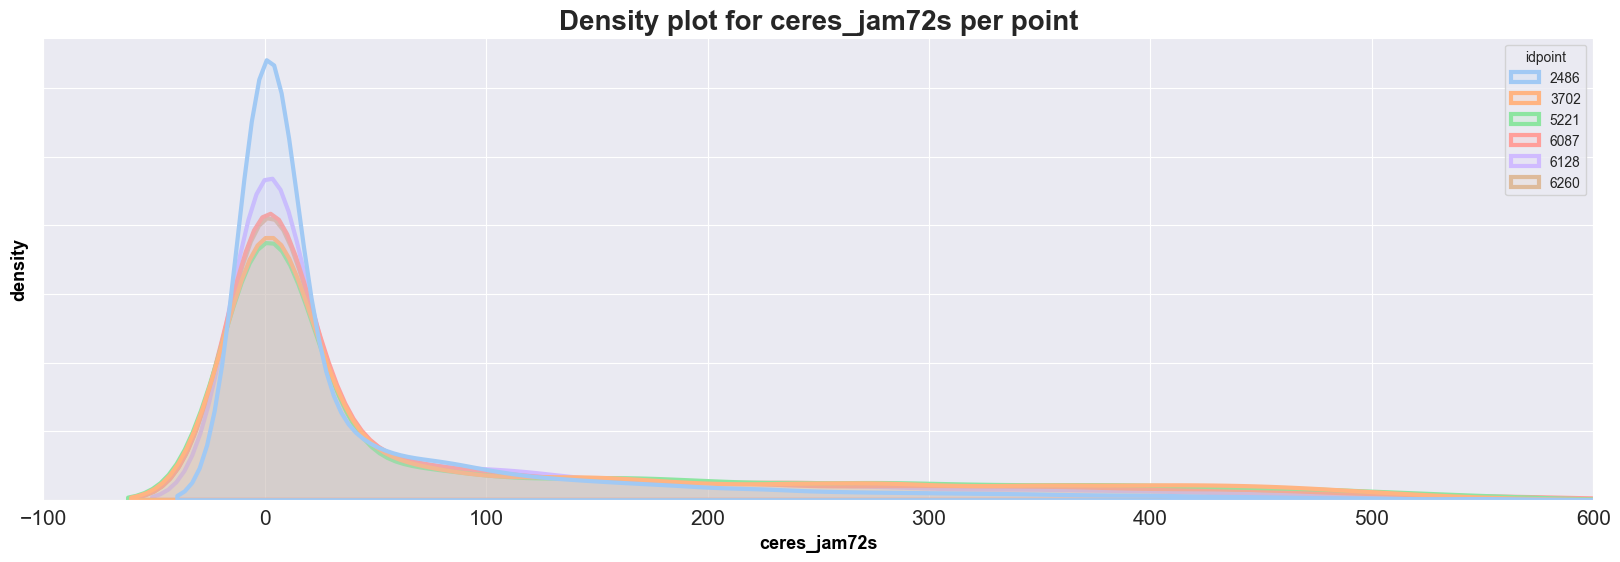

In [20]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'ceres_jam72s', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('ceres_jam72s', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-100, 600)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for ceres_jam72s per point', fontweight = 'bold', fontsize = 20);

In [21]:
data[['ceres_hevel395','ceres_jam72s']].describe()

,ceres_hevel395,ceres_jam72s
count,116208.000000,116208.000000
mean,58.809250,79.946198
std,98.364395,133.514511
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.480000,0.650000
75%,78.870003,107.709999
max,459.410004,630.659973


Из распределений функций выработки видим, что Мурманск - это точка нулевых выработок, в то время как правые хвосты остальных распределений говорят о большем разнообразии значений этих выработок.

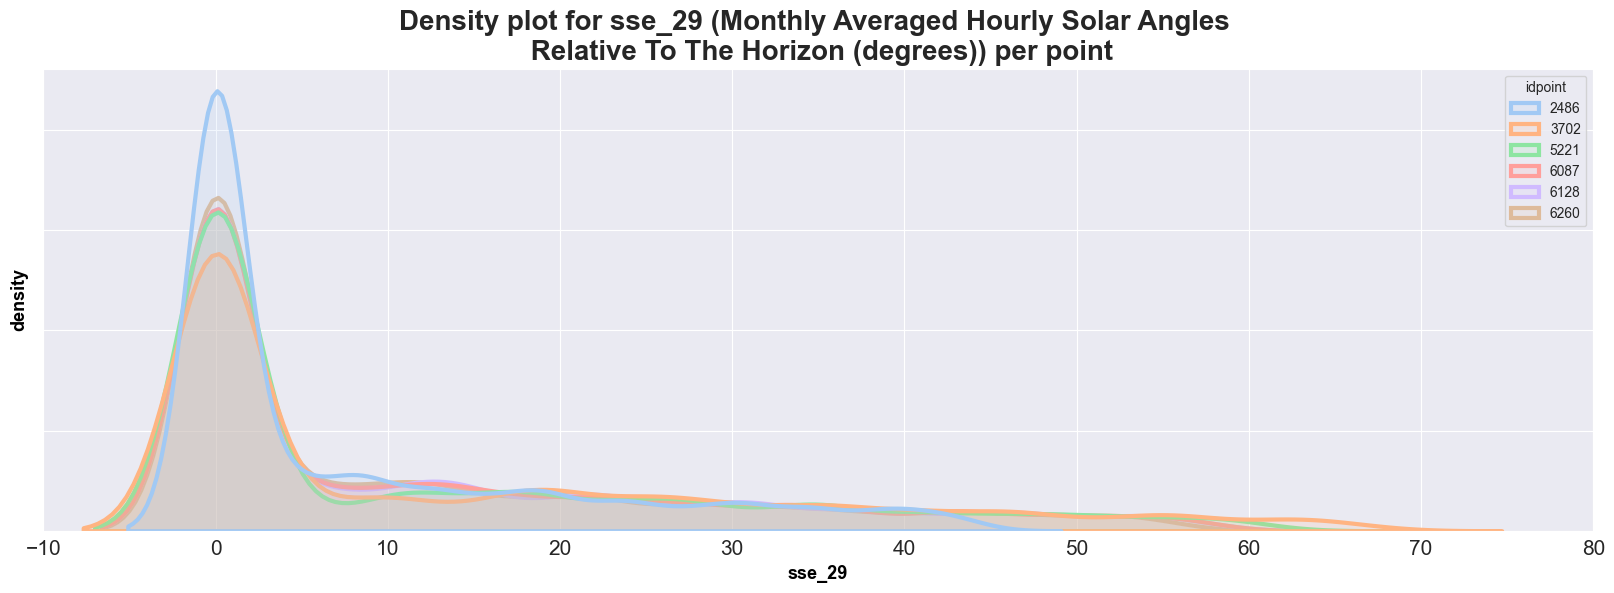

In [23]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'sse_29', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('sse_29', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-10, 80)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for sse_29 (Monthly Averaged Hourly Solar Angles \n Relative To The Horizon (degrees)) per point', fontweight = 'bold', fontsize = 20);

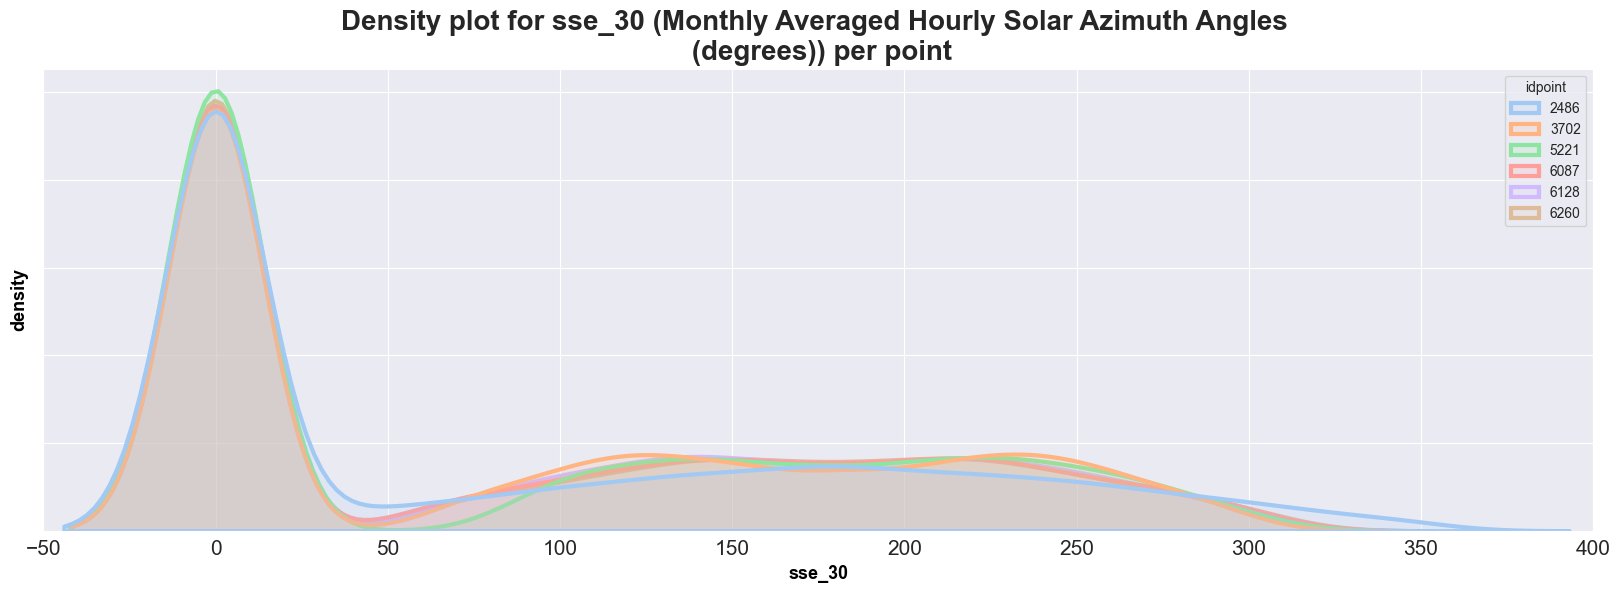

In [24]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'sse_30', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('sse_30', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-50, 400)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for sse_30 (Monthly Averaged Hourly Solar Azimuth Angles \n (degrees)) per point', fontweight = 'bold', fontsize = 20);

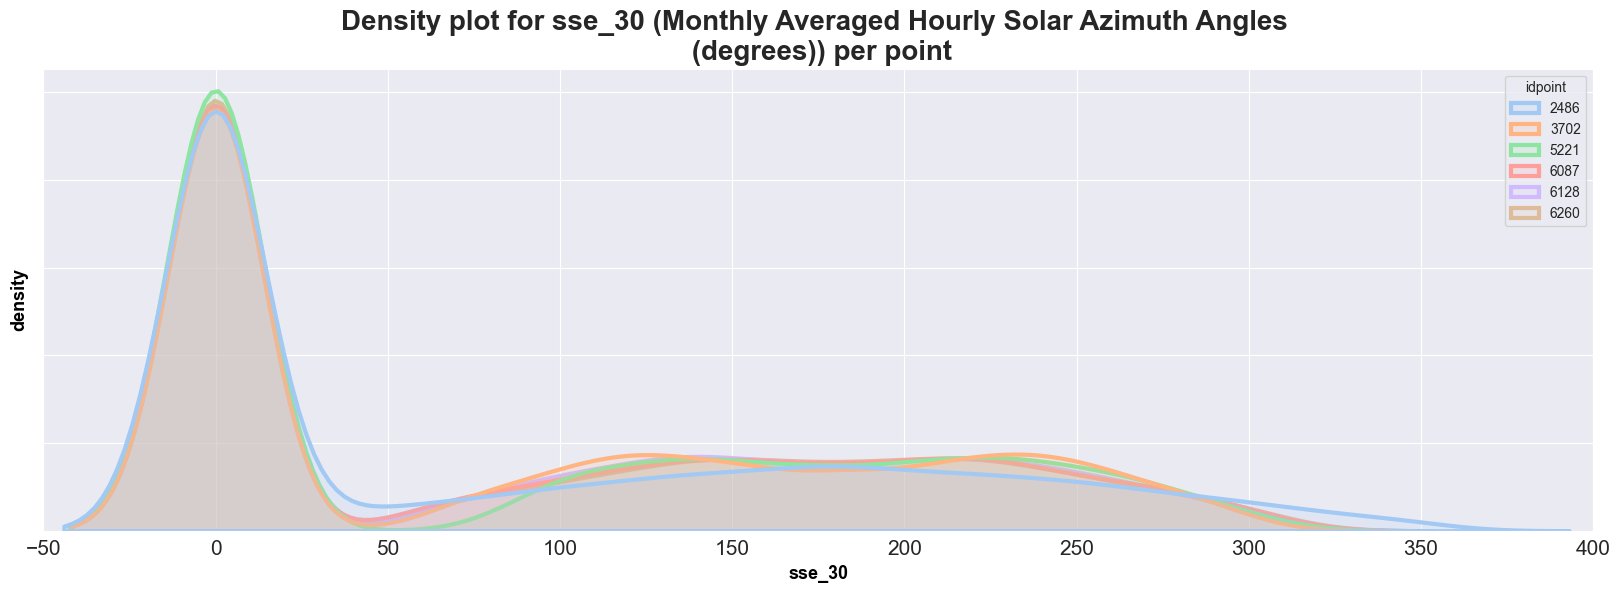

In [25]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'sse_30', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('sse_30', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-50, 400)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for sse_30 (Monthly Averaged Hourly Solar Azimuth Angles \n (degrees)) per point', fontweight = 'bold', fontsize = 20);

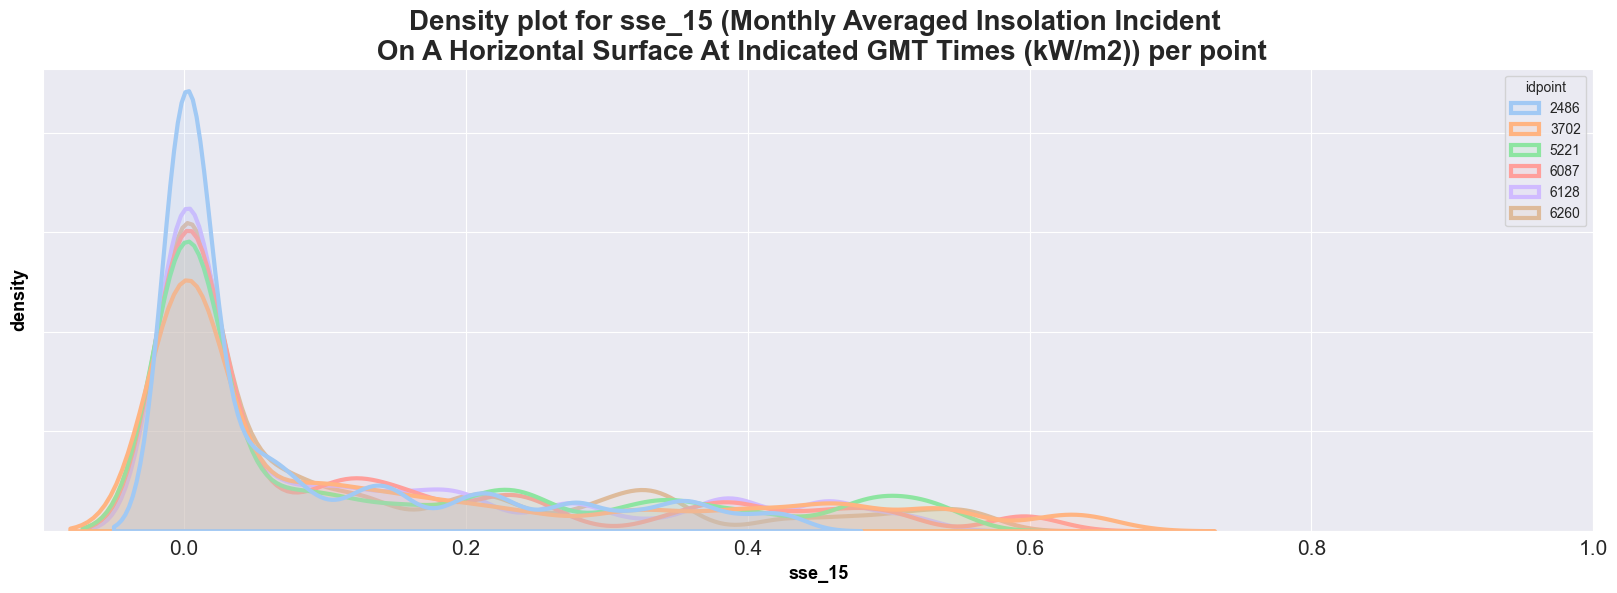

In [26]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'sse_15', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('sse_15', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-0.1, 1)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for sse_15 (Monthly Averaged Insolation Incident \n On A Horizontal Surface At Indicated GMT Times (kW/m2)) per point', fontweight = 'bold', fontsize = 20);

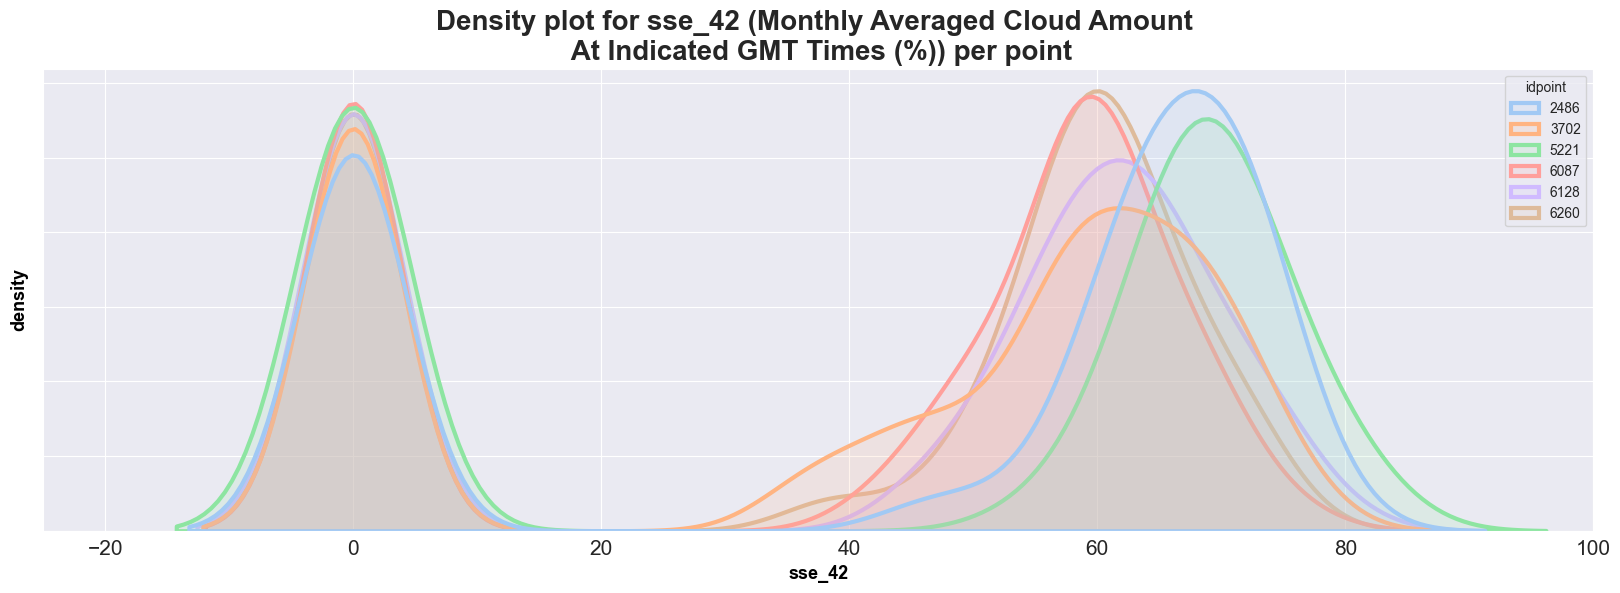

In [27]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'sse_42', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('sse_42', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-25, 100)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for sse_42 (Monthly Averaged Cloud Amount \n At Indicated GMT Times (%)) per point', fontweight = 'bold', fontsize = 20);

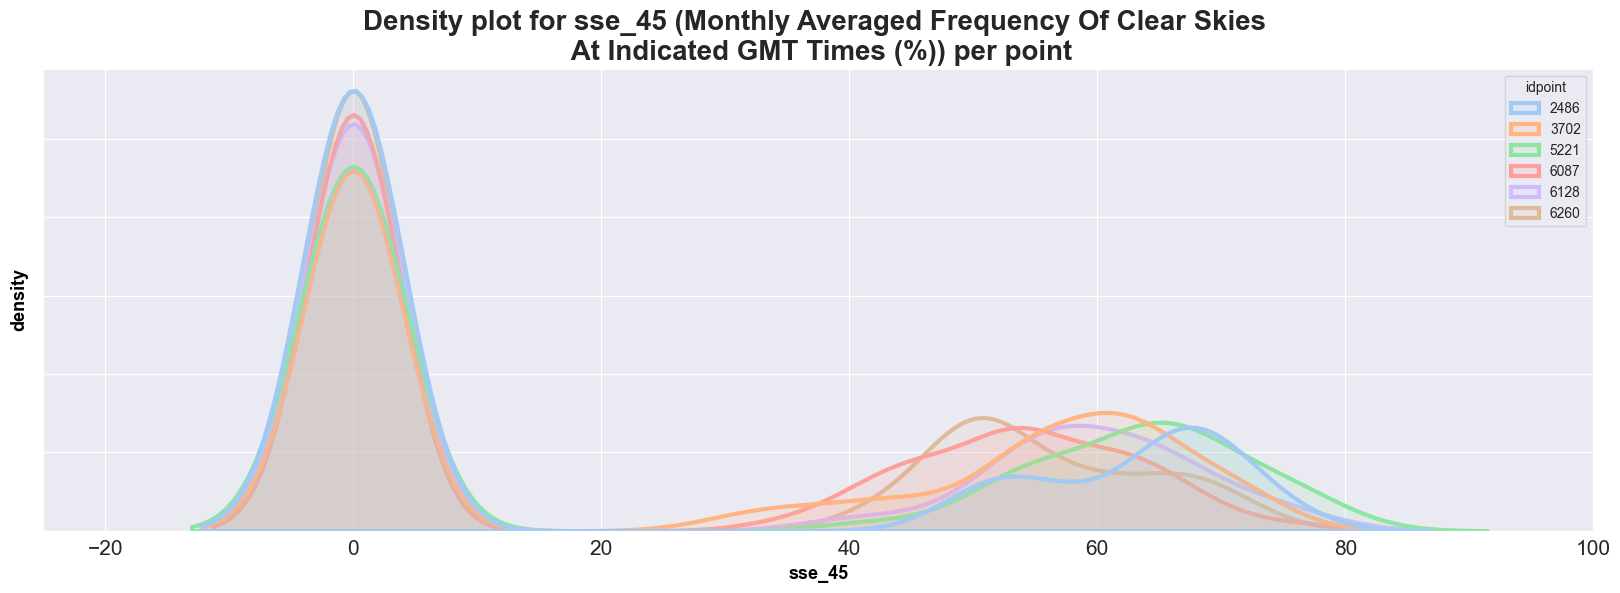

In [28]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'sse_45', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('sse_45', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-25, 100)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for sse_45 (Monthly Averaged Frequency Of Clear Skies \n At Indicated GMT Times (%)) per point', fontweight = 'bold', fontsize = 20);

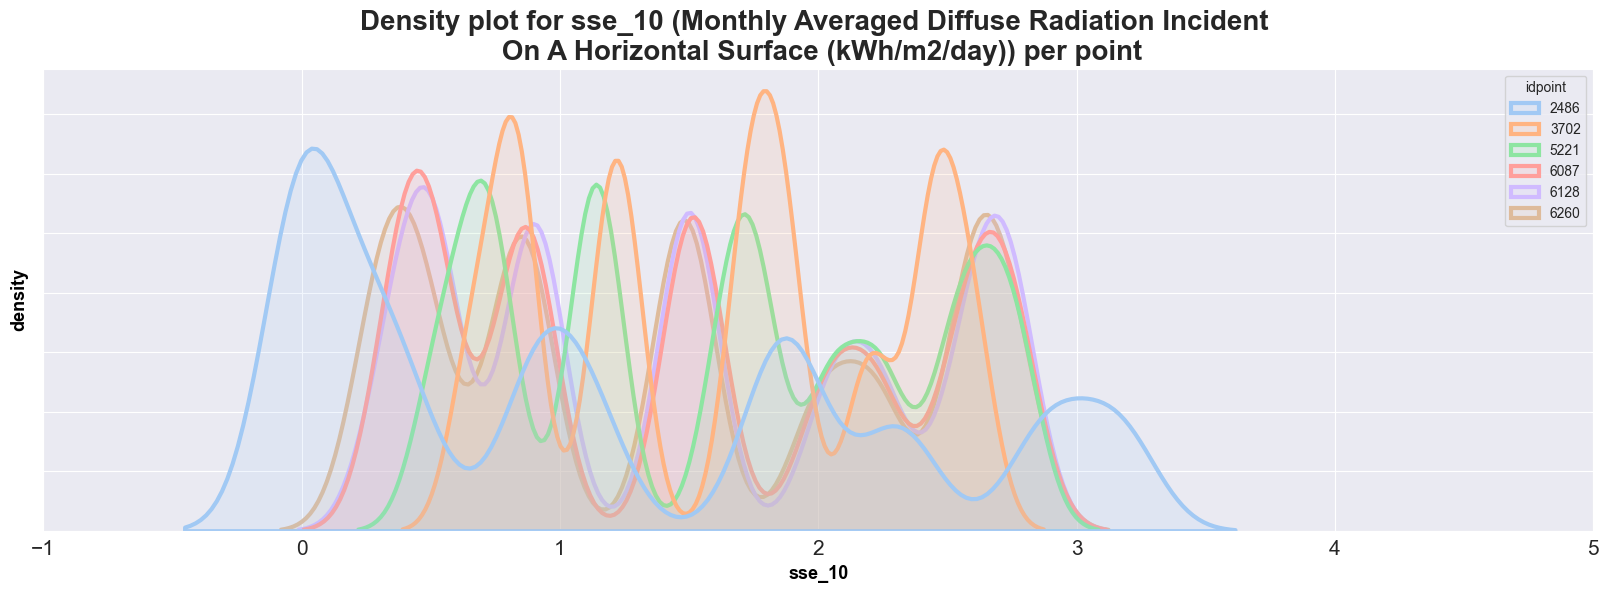

In [29]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'sse_10', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('sse_10', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-1, 5)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for sse_10 (Monthly Averaged Diffuse Radiation Incident \n On A Horizontal Surface (kWh/m2/day)) per point', fontweight = 'bold', fontsize = 20);

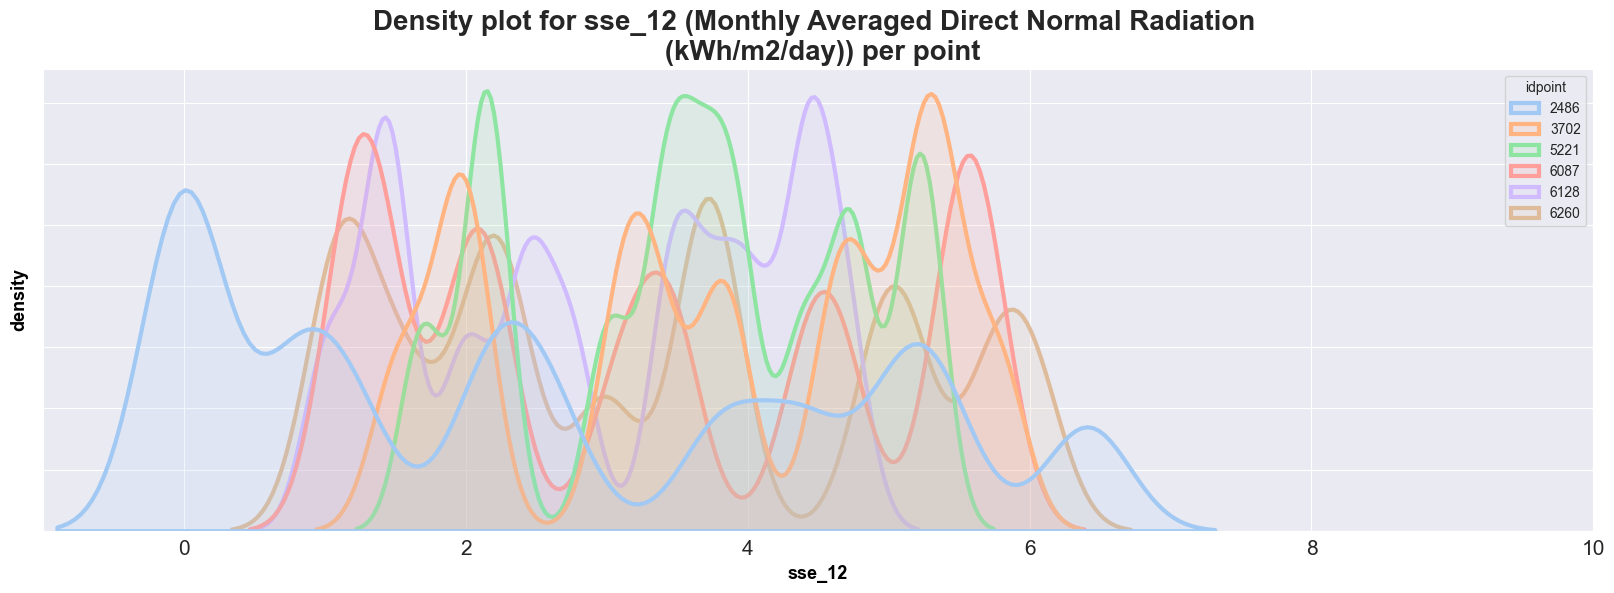

In [30]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'sse_12', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('sse_12', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-1, 10)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for sse_12 (Monthly Averaged Direct Normal Radiation \n (kWh/m2/day)) per point', fontweight = 'bold', fontsize = 20);

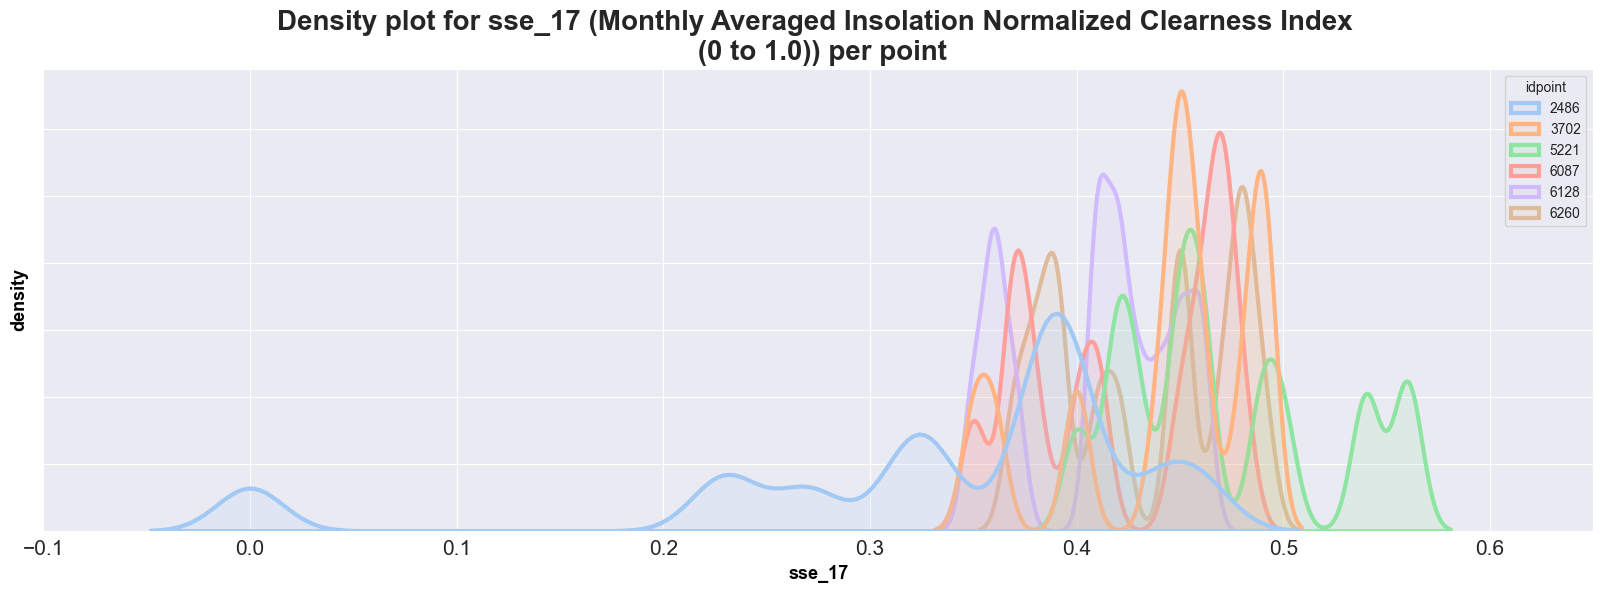

In [31]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'sse_17', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('sse_17', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-0.1, 0.65)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for sse_17 (Monthly Averaged Insolation Normalized Clearness Index \n (0 to 1.0)) per point', fontweight = 'bold', fontsize = 20);

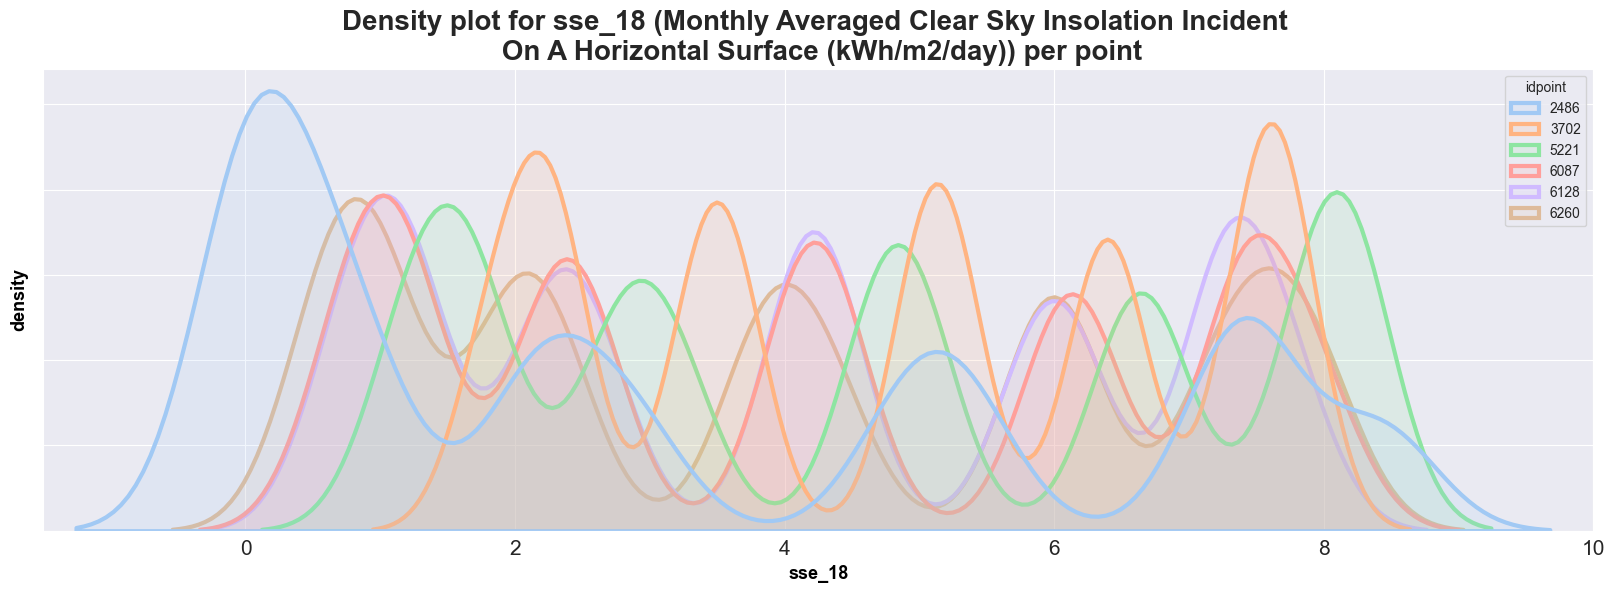

In [32]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'sse_18', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('sse_18', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-1.5, 10)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for sse_18 (Monthly Averaged Clear Sky Insolation Incident \n On A Horizontal Surface (kWh/m2/day)) per point', fontweight = 'bold', fontsize = 20);

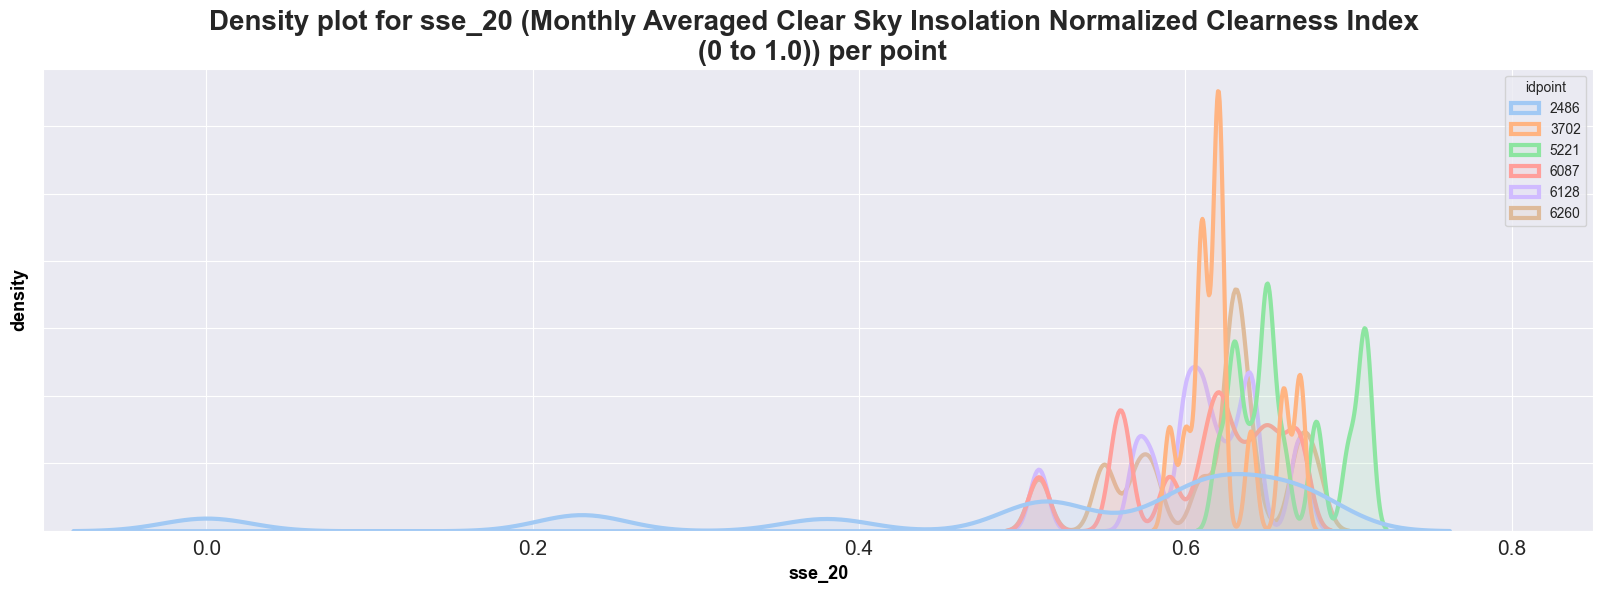

In [33]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'sse_20', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('sse_20', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-0.1, 0.85)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for sse_20 (Monthly Averaged Clear Sky Insolation Normalized Clearness Index \n (0 to 1.0)) per point', fontweight = 'bold', fontsize = 20);

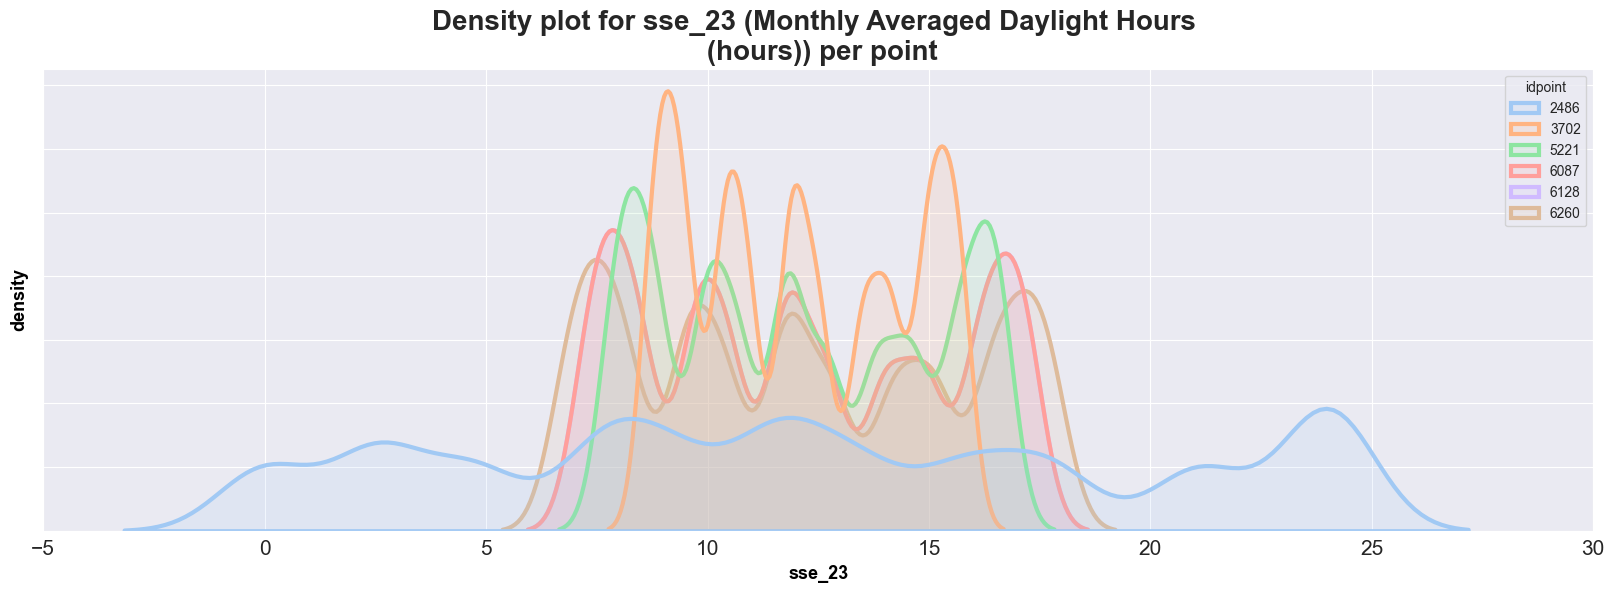

In [34]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'sse_23', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('sse_23', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-5, 30)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for sse_23 (Monthly Averaged Daylight Hours \n (hours)) per point', fontweight = 'bold', fontsize = 20);

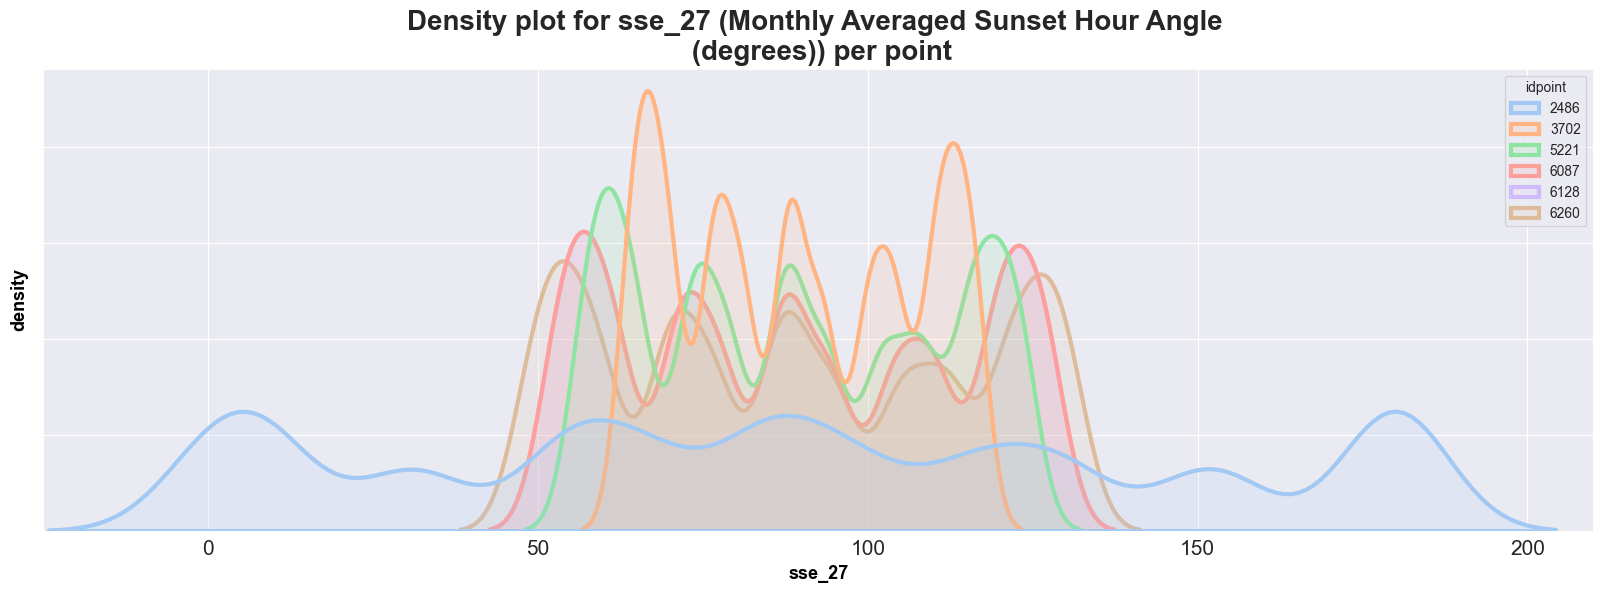

In [35]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'sse_27', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('sse_27', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-25, 210)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for sse_27 (Monthly Averaged Sunset Hour Angle \n (degrees)) per point', fontweight = 'bold', fontsize = 20);

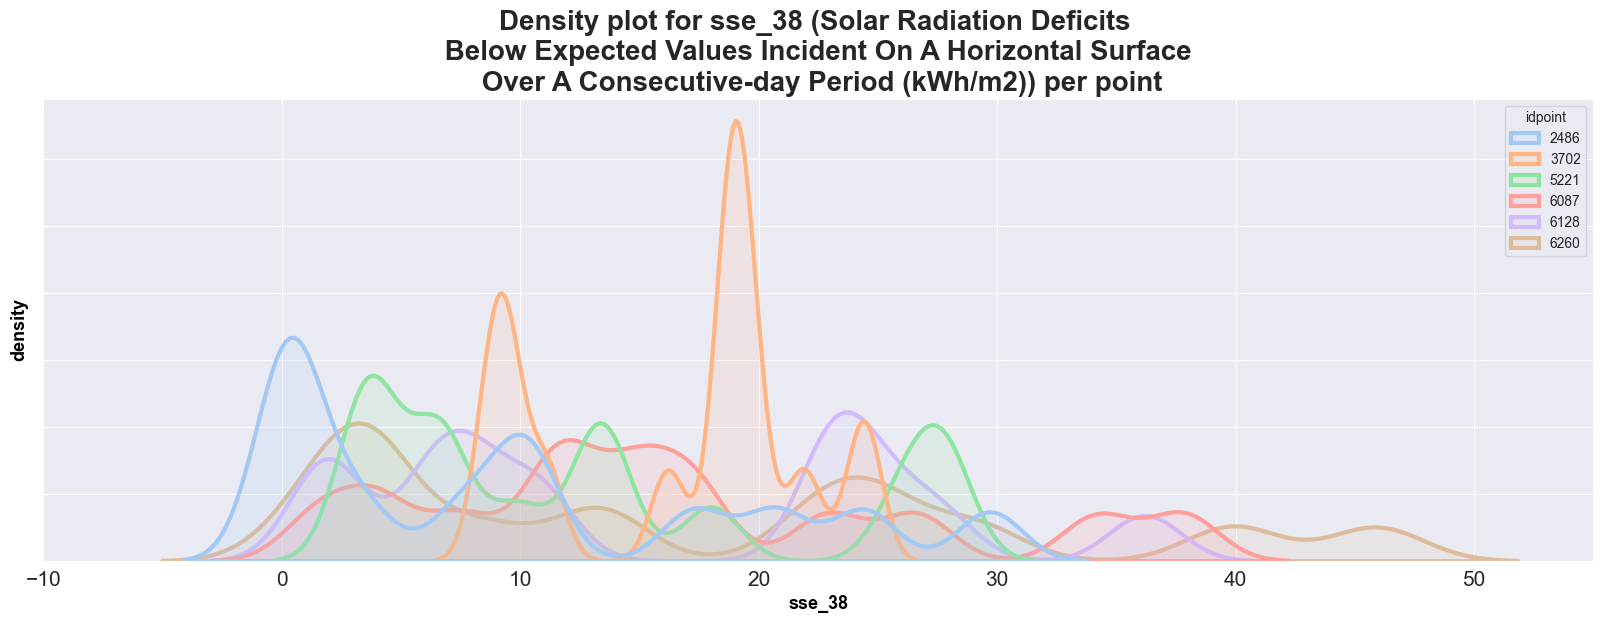

In [36]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'sse_38', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('sse_38', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-10, 55)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for sse_38 (Solar Radiation Deficits \n Below Expected Values Incident On A Horizontal Surface \n Over A Consecutive-day Period (kWh/m2)) per point', fontweight = 'bold', fontsize = 20);

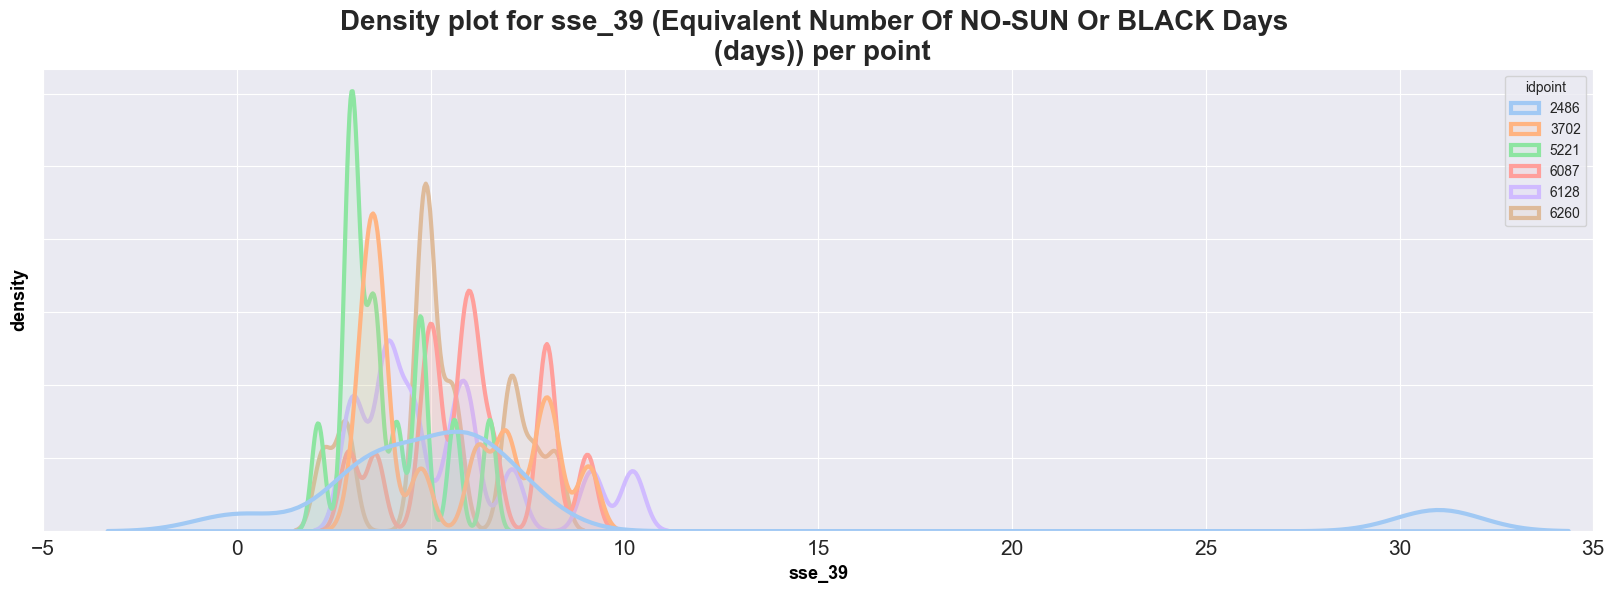

In [37]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'sse_39', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('sse_39', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-5, 35)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for sse_39 (Equivalent Number Of NO-SUN Or BLACK Days \n (days)) per point', fontweight = 'bold', fontsize = 20);

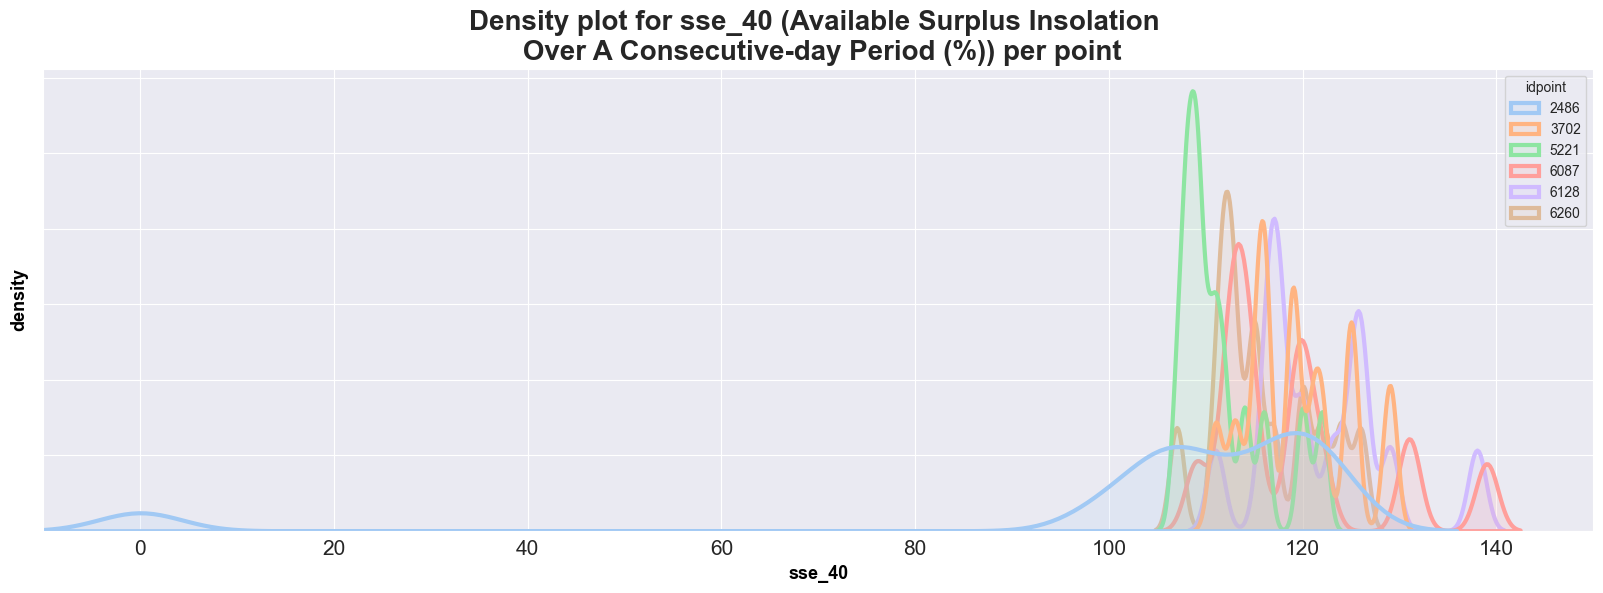

In [38]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'sse_40', hue = 'idpoint', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('sse_40', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-10, 150)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for sse_40 (Available Surplus Insolation \n Over A Consecutive-day Period (%)) per point', fontweight = 'bold', fontsize = 20);

### Корреляция признаков

In [8]:
cols = list(set(data.columns) - {"ceres_jam72s", 'ceres_5', 'ceres_6', 'ceres_t_2m',\
                                 'ceres_wind', 'ceres_albedo', \
                                'icon_hevel395', 'icon_jam72s',\
                                'es', 'subject', 'district'})

C:\Users\talic\Skillfactory\ВременныеРяды\rffi_utils.py:63: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[features].corr()


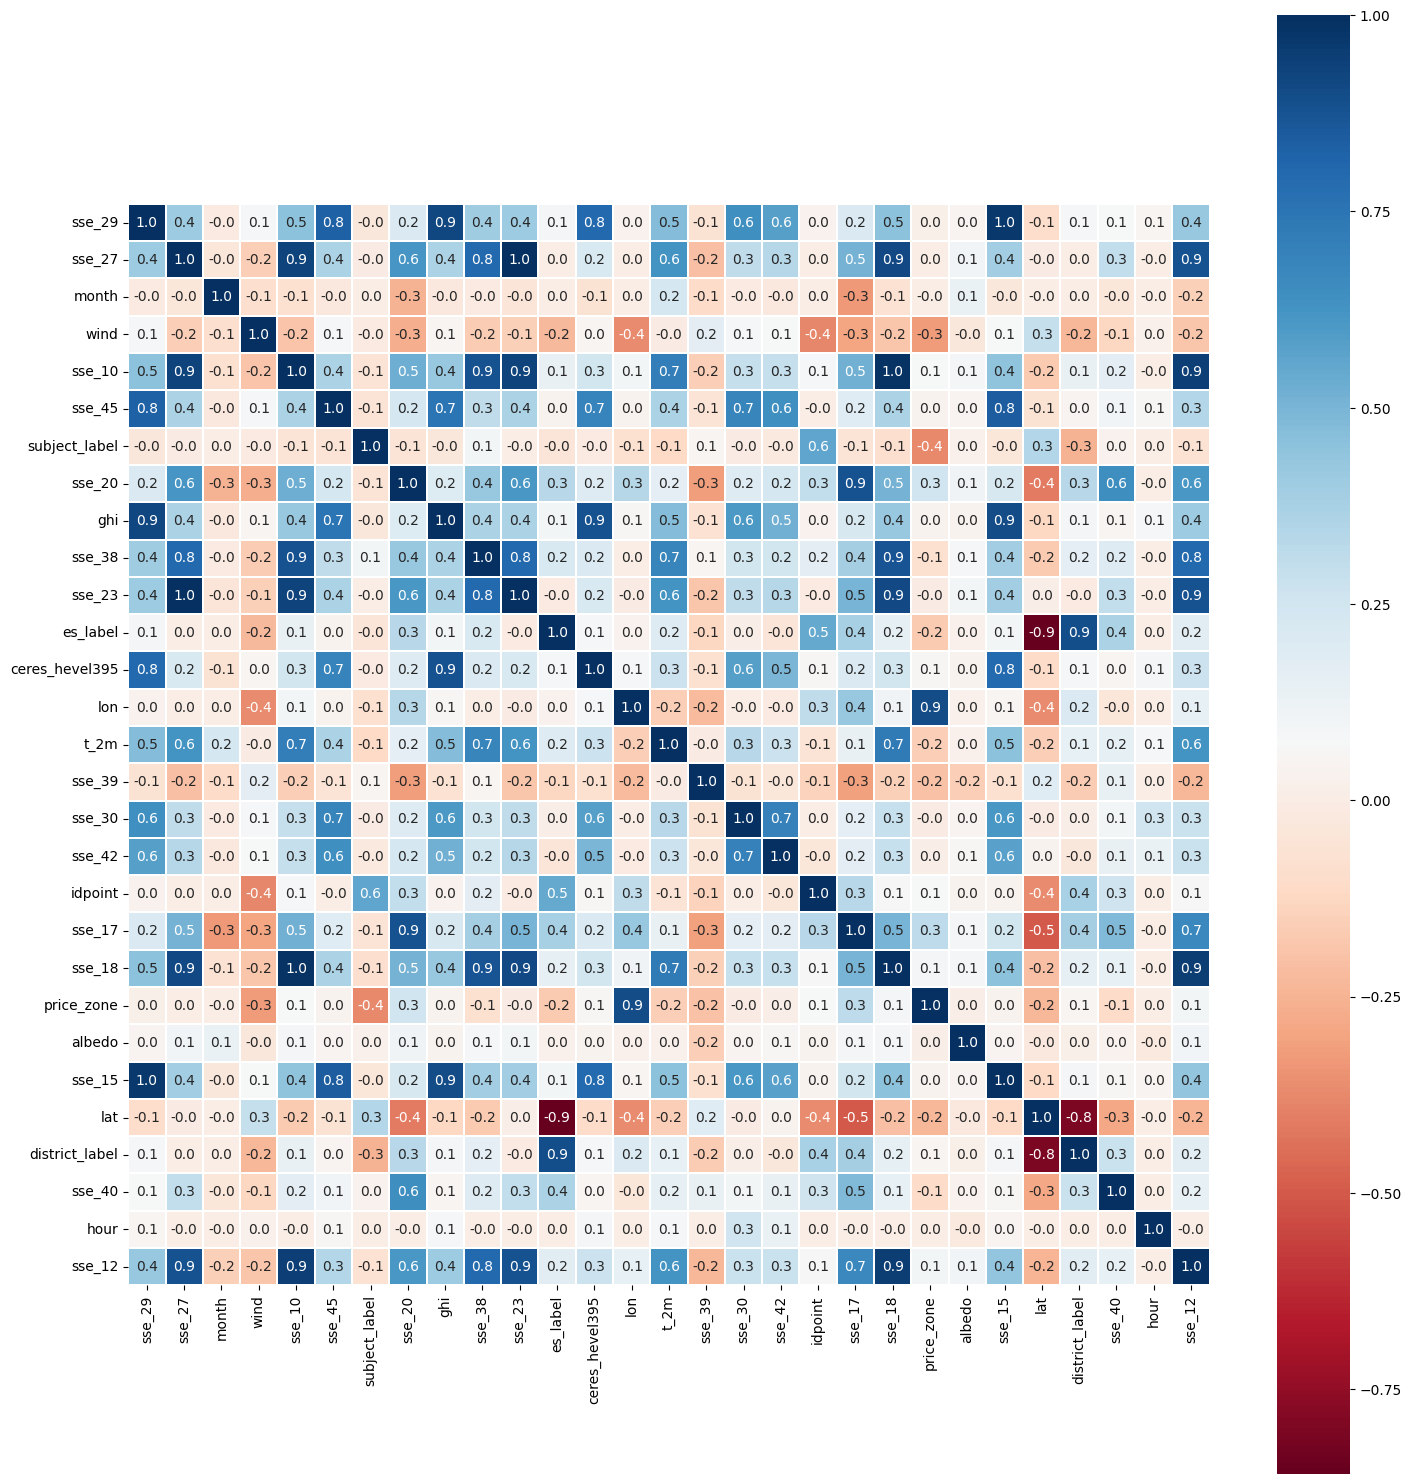

In [9]:
# Корреляция основных признаков
show_correlation(data, cols, plt, sns)

**Выводы:**
- С функцией хорошо коррелтрует только ghi (0.9) и слабо t_2m (0.3)
- зато слишком хорошо коррелируют признаки между собой:

    price_zone & lon (0.9)
    
    es_label & district_label (0.9)
    
    lat & (es_label | district_label) (-0.9)

In [10]:
# 11 вариант
cols = list(set(data.columns) - {"ceres_jam72s", 'ceres_5', 'ceres_6', 'ceres_t_2m',\
                                 'ceres_wind', 'ceres_albedo', \
                                'icon_hevel395', 'icon_jam72s',\
                                'es', 'subject', 'district','day','year',\
                                'sse_10', 'sse_12', 'sse_15','sse_23','sse_27','sse_38',\
                                'sse_17', 'sse_20', 'sse_39', 'sse_40', 'month',\
                                'subject_label', 'price_zone', 'district_label',\
                                'sse_29','hour','albedo','wind',\
                                'lat','lon','es_label', 'dow'})


C:\Users\talic\Skillfactory\ВременныеРяды\rffi_utils.py:63: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[features].corr()


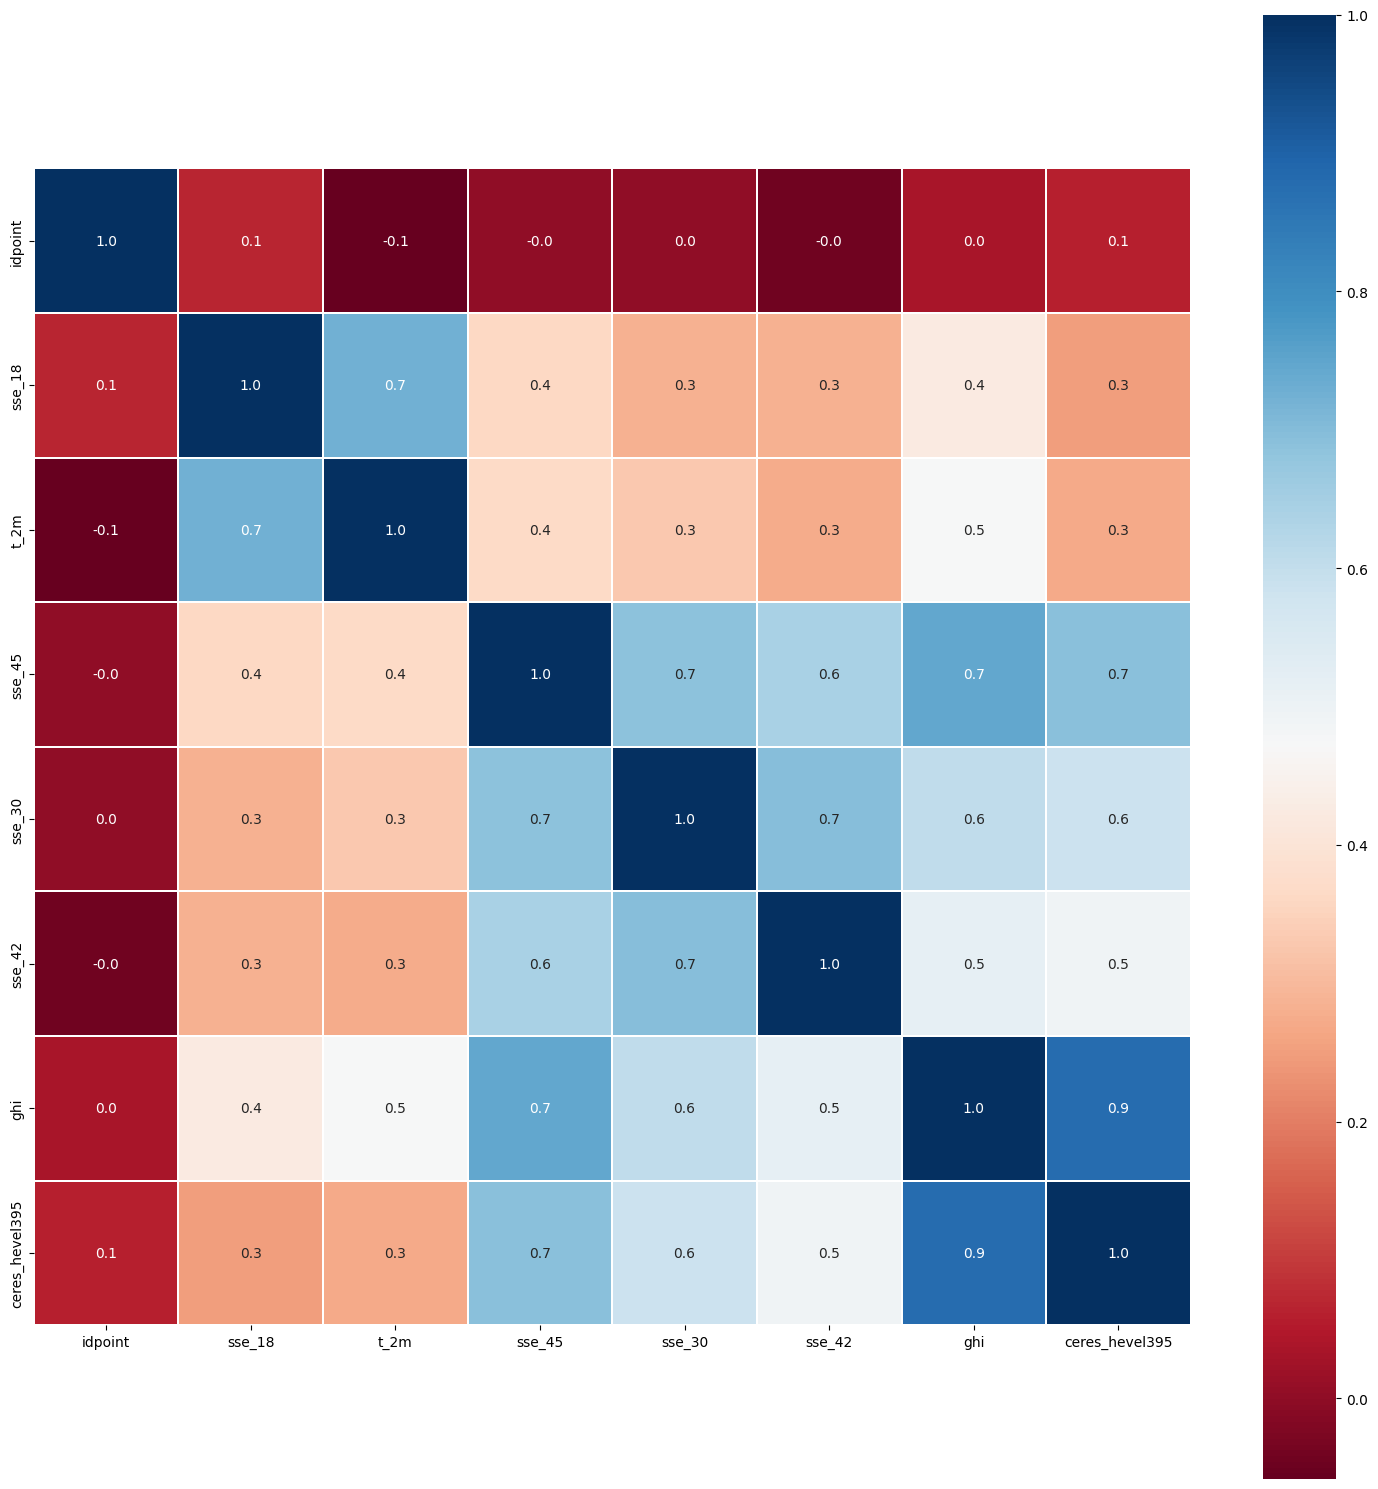

In [12]:
# Корреляция основных признаков
show_correlation(data, cols, plt, sns)

In [14]:
# Создание дополнительных временных признаков
data = create_features(data)

Text(0.5, 1.0, 'Power usage of consumers')

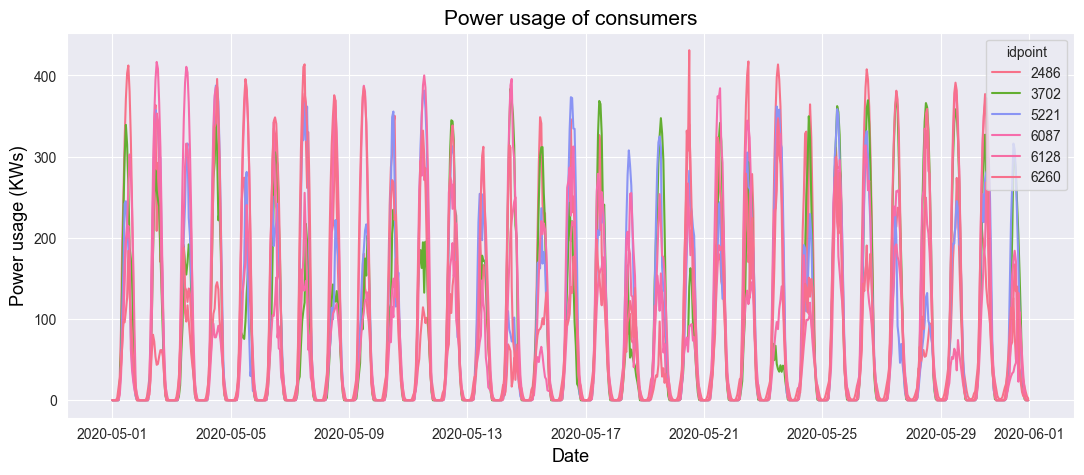

In [15]:
sns.set_style('darkgrid')
sns.color_palette("tab10")

fig, ax = plt.subplots(figsize=(13, 5))

sns.lineplot(data=data[(np.int32(data['month']) == 5)&(np.int32(data['year']) == 2020)], 
             x='datatime', 
             y='ceres_hevel395', 
             hue='idpoint', 
             legend='full',
             palette='husl').set_title('Power')

ax.set_xlabel("Date", fontdict={"color":  "black", "size": 13} )
ax.set_ylabel("Power usage (KWs)", fontdict={"color":  "black", "size": 13})
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.set_title(label = "Power usage of consumers", fontdict={"color":  "black", "size": 15})

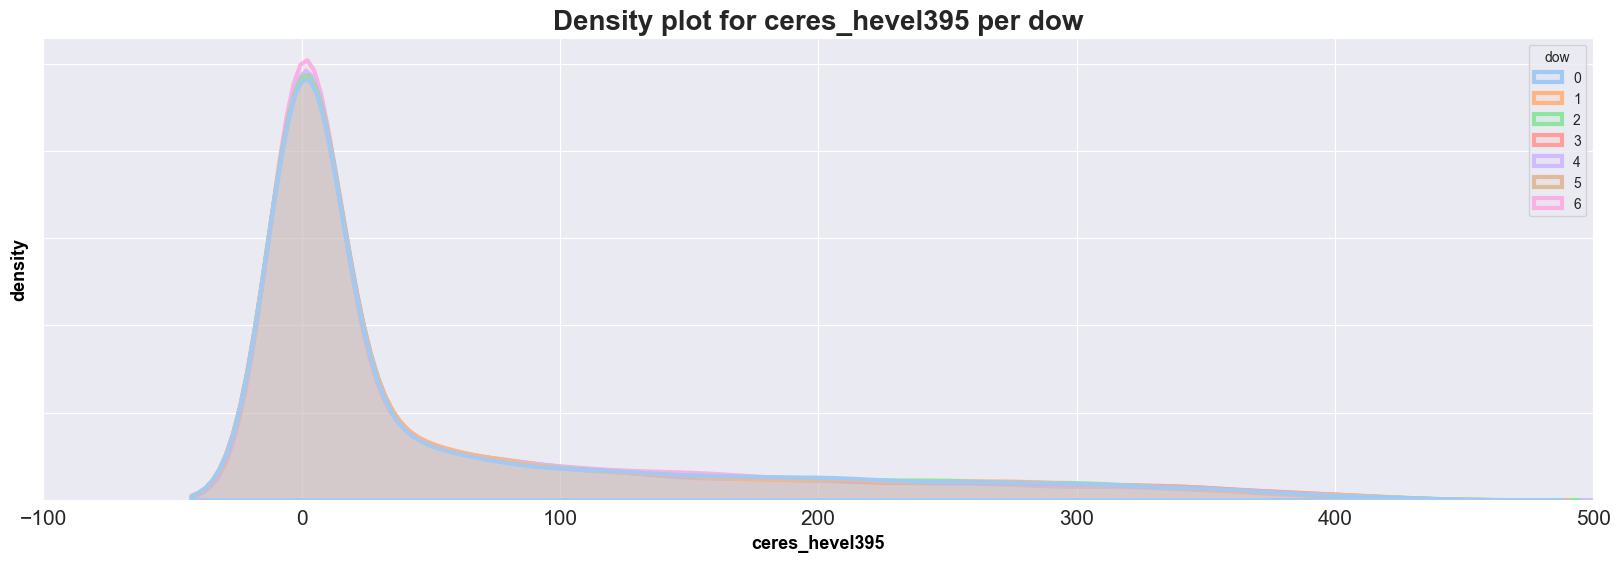

In [17]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'ceres_hevel395', hue = 'dow', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('ceres_hevel395', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-100, 500)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for ceres_hevel395 per dow', fontweight = 'bold', fontsize = 20);

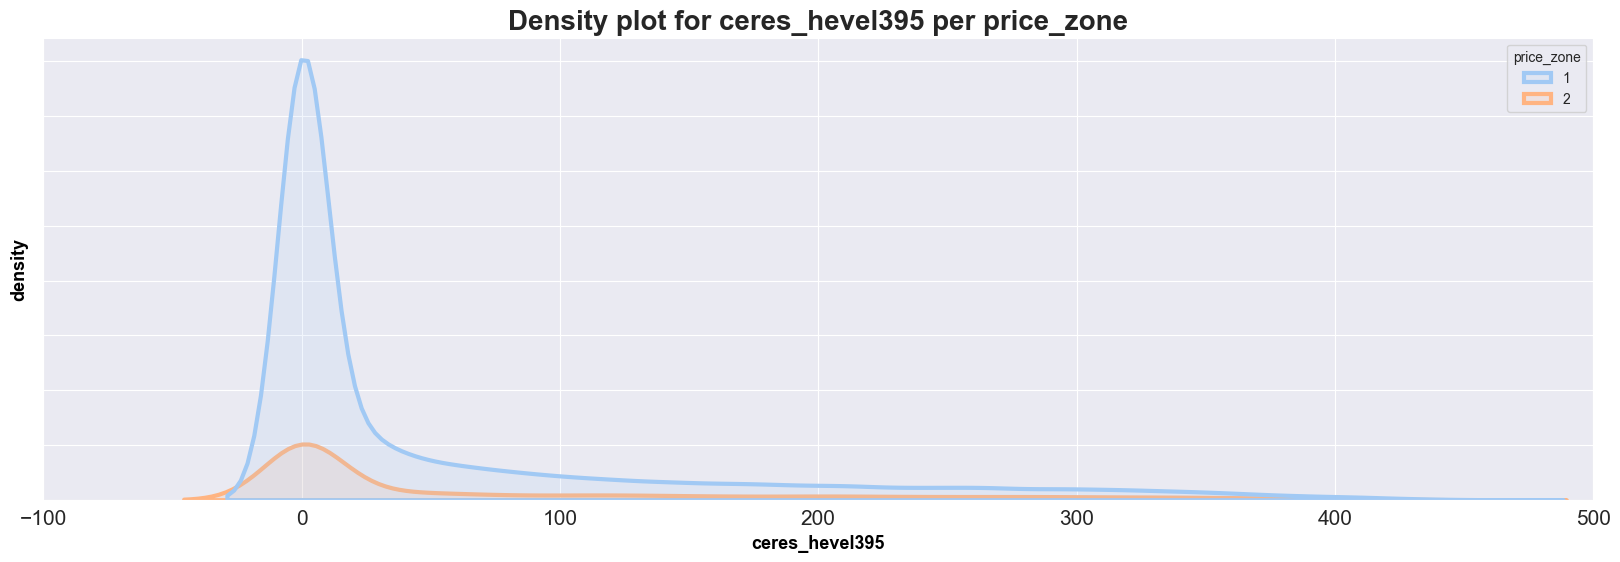

In [18]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'ceres_hevel395', hue = 'price_zone', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('ceres_hevel395', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-100, 500)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for ceres_hevel395 per price_zone', fontweight = 'bold', fontsize = 20);

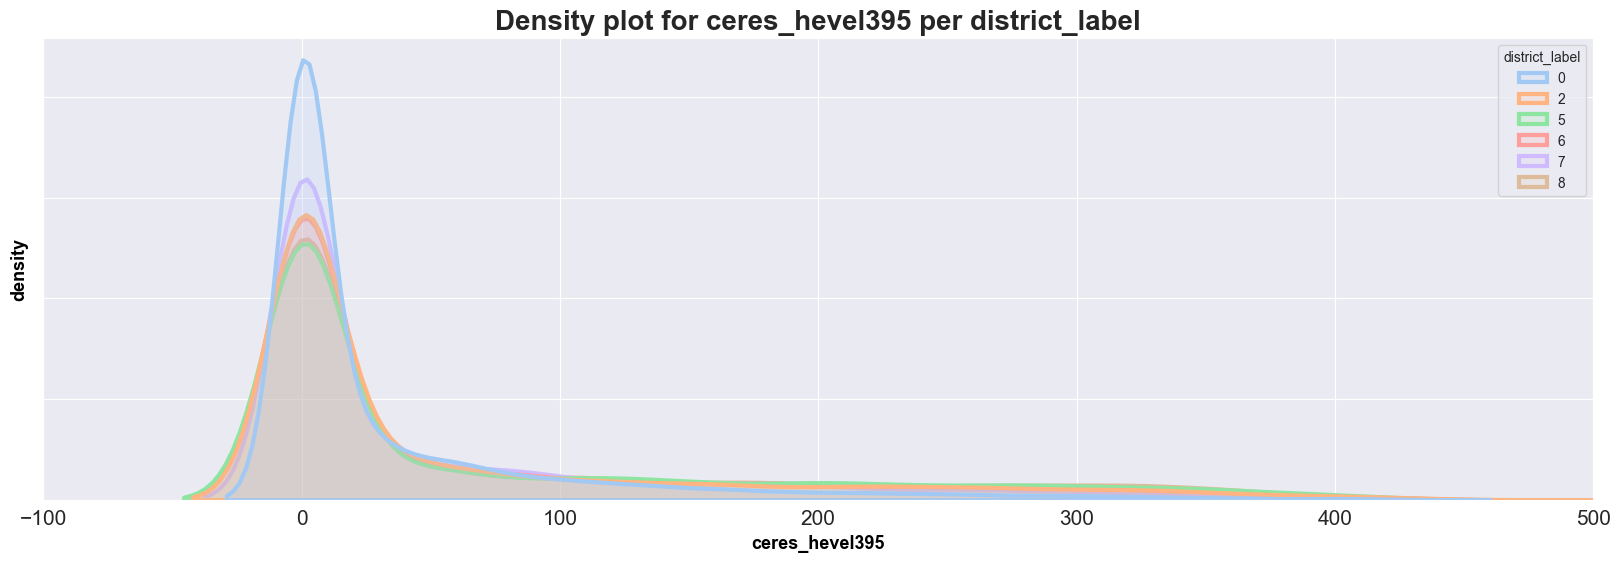

In [19]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data, x = 'ceres_hevel395', hue = 'district_label', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('ceres_hevel395', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-100, 500)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for ceres_hevel395 per district_label', fontweight = 'bold', fontsize = 20);

In [24]:
'''
index_cutoff = 6*8760*2
time_df2 = data[cols][index_cutoff:index_cutoff+6*24*7].copy()
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
sns.lineplot(x='datatime',y='ceres_hevel395',hue='idpoint',data=(time_df2.groupby(['datatime', 'idpoint']).ceres_hevel395.sum().rename('ceres_hevel395')
                                                       .reset_index().sort_values('datatime', ascending = True, ignore_index=True)), linewidth = 2, alpha = 0.7, palette='pastel')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120)) 
ax.set_xlabel('datatime', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('ceres_hevel395', color='black', fontweight='bold', fontsize=13)
ax.legend(fontsize = 20, loc = 'upper left')
ax.set_title('ceres_hevel395 per point and Date', fontweight = 'bold', fontsize = 20);
'''

"\nindex_cutoff = 6*8760*2\ntime_df2 = data[cols][index_cutoff:index_cutoff+6*24*7].copy()\nfig, ax = plt.subplots(1, 1, figsize = (20, 8))\nsns.lineplot(x='datatime',y='ceres_hevel395',hue='idpoint',data=(time_df2.groupby(['datatime', 'idpoint']).ceres_hevel395.sum().rename('ceres_hevel395')\n                                                       .reset_index().sort_values('datatime', ascending = True, ignore_index=True)), linewidth = 2, alpha = 0.7, palette='pastel')\n#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))\n#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120)) \nax.set_xlabel('datatime', color='black', fontweight='bold', fontsize=13)\nax.set_ylabel('ceres_hevel395', color='black', fontweight='bold', fontsize=13)\nax.legend(fontsize = 20, loc = 'upper left')\nax.set_title('ceres_hevel395 per point and Date', fontweight = 'bold', fontsize = 20);\n"